# Instructions

**Contexte** : Vous êtes Lead Data Scientist dans une entreprise industrielle. Un projet vise à mettre en place un système de maintenance prédictive pour les machines de l'usine et à analyser les causes qui font que la condition de la valve d'un cycle de production est non optimale parfois.

**Objectif de l'exercice** : Construisez un modèle ML pour prédire si la condition valve est optimale (=100%) ou non, pour chaque cycle. Vous utiliserez les 2000 premiers cycles pour construire le modèle et le reste comme échantillon de test final.   

**Données** : Utiliser les données des capteurs PS2 et FS1 décrites dans le lien suivant : https://archive.ics.uci.edu/dataset/447/condition+monitoring+of+hydraulic+systems. 

# Code

## a. Import des bibliothèques

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid')

## b. Chargement des données

In [2]:
"""
Charge les fichiers de données FS1, PS2 et profile.
    
Returns:
    X (pd.DataFrame): Les features combinées provenant des fichiers FS1 et PS2.
    y (pd.Series): La cible (condition de la valve) provenant du fichier profile.
"""
def load_data():
    base_dir = os.path.dirname(os.getcwd())

    profile_path = os.path.join(base_dir, "data_subset", "profile.txt")
    fs1_path = os.path.join(base_dir, "data_subset", "FS1.txt")
    ps2_path = os.path.join(base_dir, "data_subset", "PS2.txt")

    names = ["cooler_condition", "valve_condition", "internal_pump_leakage", "hydraulic_accumulator", "stable_flag"]
    profile = pd.read_csv(profile_path, sep="\s+", names=names)
    fs1 = pd.read_csv(fs1_path, sep="\s+", header=None)
    ps2 = pd.read_csv(ps2_path, sep="\s+", header=None)

    X = pd.concat([fs1, ps2], axis=1, keys=['fs1', 'ps2'])
    y = profile["valve_condition"]

    return X, y

In [3]:
X, y = load_data()

## c. Exploration des données

In [4]:
"""
Visualise les signaux d'un capteur en fonction de la condition de la valve (cible).

Args:
    sensor (pd.DataFrame): Données du capteur (ex. PS2 ou FS1), chaque ligne représente un cycle, chaque colonne un attribut.
    target (pd.Series): Valeurs cibles (condition de la valve) associées aux cycles (ex. 100 pour condition optimale).
    sensor_name (str): Nom du capteur à utiliser dans le titre du graphique (ex. "PS2").
    
Returns:
    None: La fonction affiche simplement le graphique.
"""
def plot_sensor_by_target(sensor, target, sensor_name="Sensor"):
    
    unique_classes = target.unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_classes)))  # Palette discrète de couleurs
    class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

    plt.figure(figsize=(10, 6))

    for i in range(sensor.shape[0]):
        class_value = target.iloc[i]
        plt.plot(sensor.iloc[i, :], color=class_to_color[class_value], alpha=0.5)

    for cls in unique_classes:
        plt.plot([], [], color=class_to_color[cls], label=f'{cls}')

    plt.legend(title='Valve condition', loc='lower right')

    plt.xlabel('Attributs du capteur')
    plt.ylabel('Valeurs du signal')
    plt.title(f'Signaux du capteur {sensor_name} par condition de valve')

    plt.show()

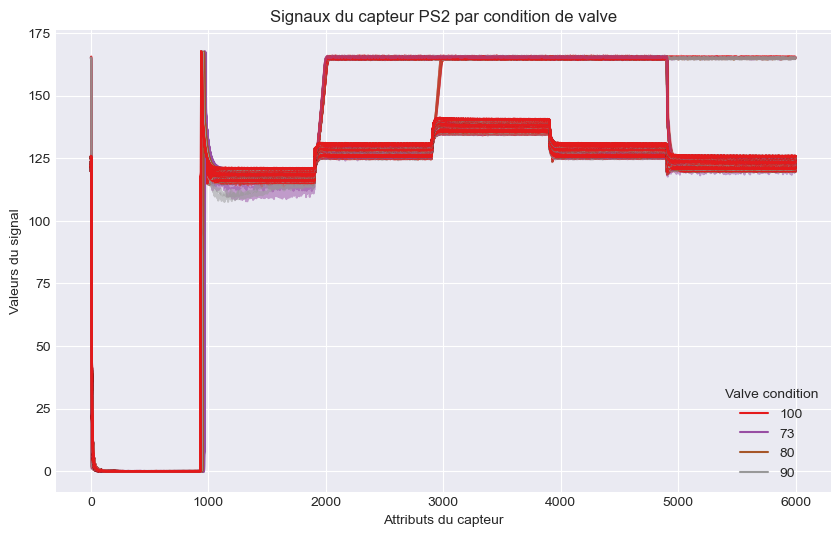

In [5]:
plot_sensor_by_target(X['ps2'], y, 'PS2')

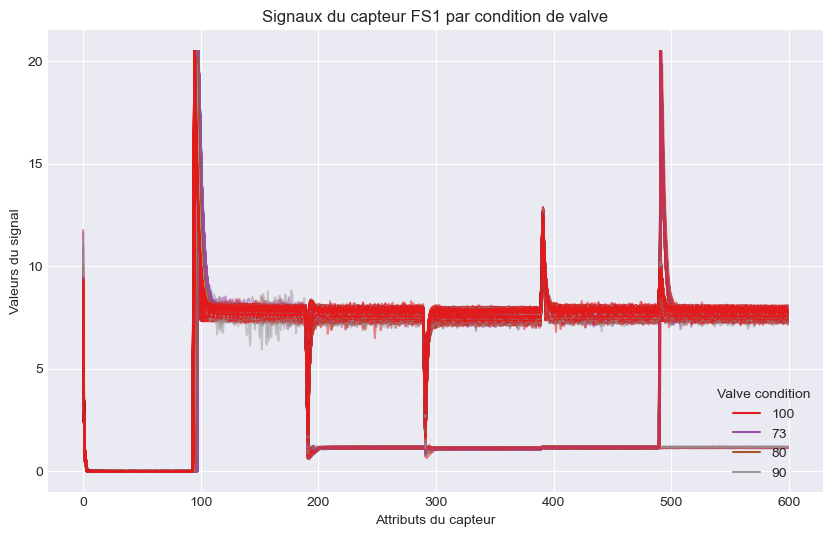

In [6]:
plot_sensor_by_target(X['fs1'], y, 'FS1')

## d. Séparation des données, entraînement et évaluation du modèle

In [7]:
"""
Sépare les données, entraîne puis retourne un modèle RandomForest et sa fiabilité sur l'ensemble de test.

Args:
    X (pd.DataFrame): Le jeu de données contenant les variables d'entrée (ex. FS1, PS2).
    y (pd.Series): Les étiquettes cibles (condition de la valve).
    training_samples (int, optional): Le nombre d'échantillons à utiliser pour l'apprentissage. 
                                      Par défaut, 2000. Doit être compris entre 1 et 2204.
    plot_cm (bool, optional): Indique si l'on affiche ou non la matrice de confusion.

Returns:
    rf (RandomForestClassifier): Le modèle entraîné sur les données d'apprentissage.
    accuracy (float): La précision du modèle sur l'ensemble de test (données non vues).
    
Raises:
    ValueError: Si `training_samples` est inférieur ou égal à 0 ou supérieur au nombre total d'échantillons.
    
"""
def train_model(X, y, training_samples=2000, plot_cm=True):
    if training_samples <= 0 or training_samples >= X.shape[0]:
        raise ValueError("Le nombre d'échantillons d'apprentissage doit être compris entre 1 et 2204.")
    
    X_train, y_train = X[:training_samples], y[:training_samples]
    X_test, y_test = X[training_samples:], y[training_samples:]
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    accuracy = rf.score(X_test, y_test)
    
    if plot_cm:
        y_pred = rf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title("Matrice de confusion")
        plt.xlabel("Prédictions")
        plt.ylabel("Vérités terrain")
        plt.show()
    
    return rf, accuracy

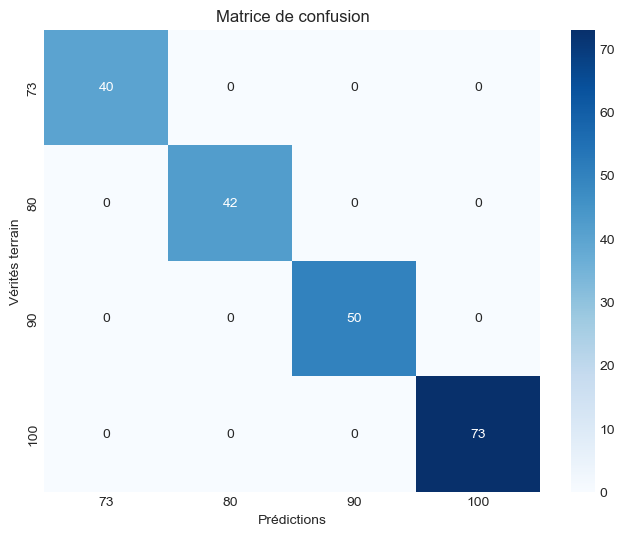

Fiabilité sur l'ensemble de test : 1.0


In [8]:
rf, accuracy = train_model(X, y)
print(f"Fiabilité sur l'ensemble de test : {accuracy}")

**Observations**:
- Une simple instance de RandomForest avec les hyperparamètres par défaut et 2000 exemples d'apprentissage (les 2000 premiers cycles) donne une *accuracy* parfaite, y compris sur les classes minoritaires (où la valve dysfonctionne).
- RandomForest est intéressant à utiliser pour apprécier la performance avant toute réduction de dimensionnalité, rééquilibrage des classes ou normalisation de données. C'est en outre un algorithme assez rapide.
- Notre mesure d'exactitude de 1.0 est confirmée par la littérature : *Cooler and Valve states are "easy" targets (perfect classification achieved)*.
- L'un des grands avantages de RandomForest est aussi son interprétabilité : on peut chercher quelles variables sont les plus influentes dans la prévision, ce que nous faisons ci-dessous.

## e. Interprétabilité du modèle
##### Quelles sont les causes qui font que la condition de la valve d'un cycle de production est non optimale parfois ?

In [9]:
"""
Affiche une matrice de corrélation entre les variables les plus influentes, les moins influentes et la condition de la valve.

Args:
    X (pd.DataFrame): Les données d'entrée contenant les capteurs FS1 et PS2.
    y (pd.Series): La cible à prédire (ici, la condition de la valve).
    rf (RandomForestClassifier): Le modèle de forêt aléatoire entraîné, contenant l'attribut `feature_importances_` 
                                 qui donne l'importance de chaque variable.
    most (int, optional): Le nombre de variables les plus influentes à sélectionner pour l'affichage de la corrélation. 
                          Par défaut, 5.
    least (int, optional): Le nombre de variables les moins influentes à sélectionner pour l'affichage de la corrélation.
                           Par défaut, 5.
    
Returns:
    None
"""
def plot_correlation_matrix(X, y, rf, most=5, least=5):
    features = { k:v for k, v in zip(X.columns, rf.feature_importances_) }
    sorted_features = sorted(features.items(), key=lambda x: x[1], reverse=True)
    most_important_features = sorted_features[:most]
    least_important_features = sorted_features[-least:]
    
    most_important_features_names = [feature for feature, importance in most_important_features]
    least_important_features_names = [feature for feature, importance in least_important_features]

    selected_features = most_important_features_names + least_important_features_names
    X_important = X[selected_features].copy()
    X_important['valve_condition'] = y

    correlation_matrix = X_important.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title("Matrice de corrélation des variables les plus/moins influentes et de la condition de la valve")
    plt.show()

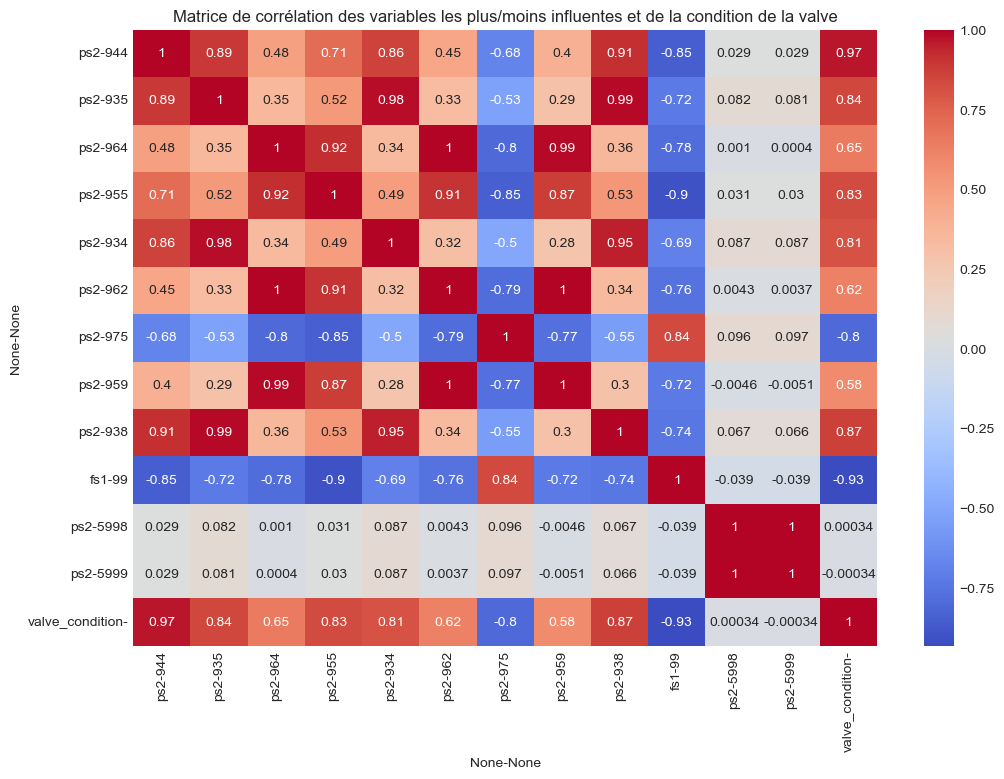

In [10]:
plot_correlation_matrix(X, y, rf, 10, 2)

**Observations**: 
- La matrice de corrélation permet de montrer que certaines variables sont très corrélées (positivement ou négativement) à l'état de la valve.
- Affichons ci-dessous l'importance des attributs pour chaque capteur, en fonction du moment du cycle où la mesure est prise.

In [11]:
"""
Affiche l'importance des caractéristiques pour un capteur spécifique, basé sur les importances fournies
par un modèle RandomForestClassifier.

Args:
    sensor_data (pd.DataFrame): Données des capteurs.
    feature_importances (np.array): Les importances des caractéristiques globales du modèle.
    sensor_name (str): Nom du capteur à afficher dans le titre (ex: 'FS1' ou 'PS2').

Returns:
    None: La fonction affiche un graphique montrant l'importance des caractéristiques du capteur.
"""
def plot_sensor_importances(X, feature_importances, sensor_name):
    if sensor_name == 'FS1':
        color = 'blue'
        sensor_data = X['fs1']
        start_idx = 0
    elif sensor_name == 'PS2':
        color = 'green'
        sensor_data = X['ps2']
        start_idx = X['fs1'].shape[1]
    else:
        raise ValueError("Unknown sensor. Only FS1 and PS2 currently available.")
    
    n_columns = sensor_data.shape[1]
    
    plt.figure(figsize=(14, 6))
    plt.bar(range(n_columns), feature_importances[start_idx:start_idx + n_columns], color=color, label=sensor_name, alpha=0.7)
    
    plt.xlabel(f"Index des caractéristiques {sensor_name}")
    plt.ylabel("Importance des caractéristiques")
    plt.title(f"Importance des caractéristiques pour {sensor_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

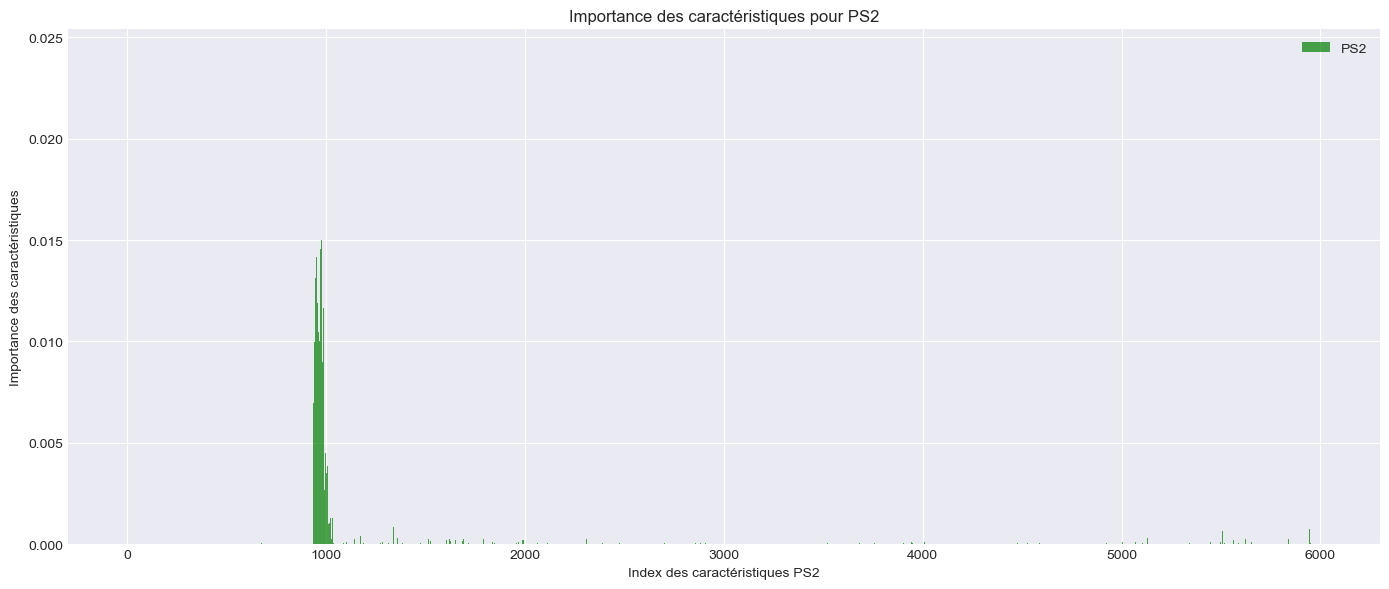

In [12]:
plot_sensor_importances(X, rf.feature_importances_, sensor_name="PS2")

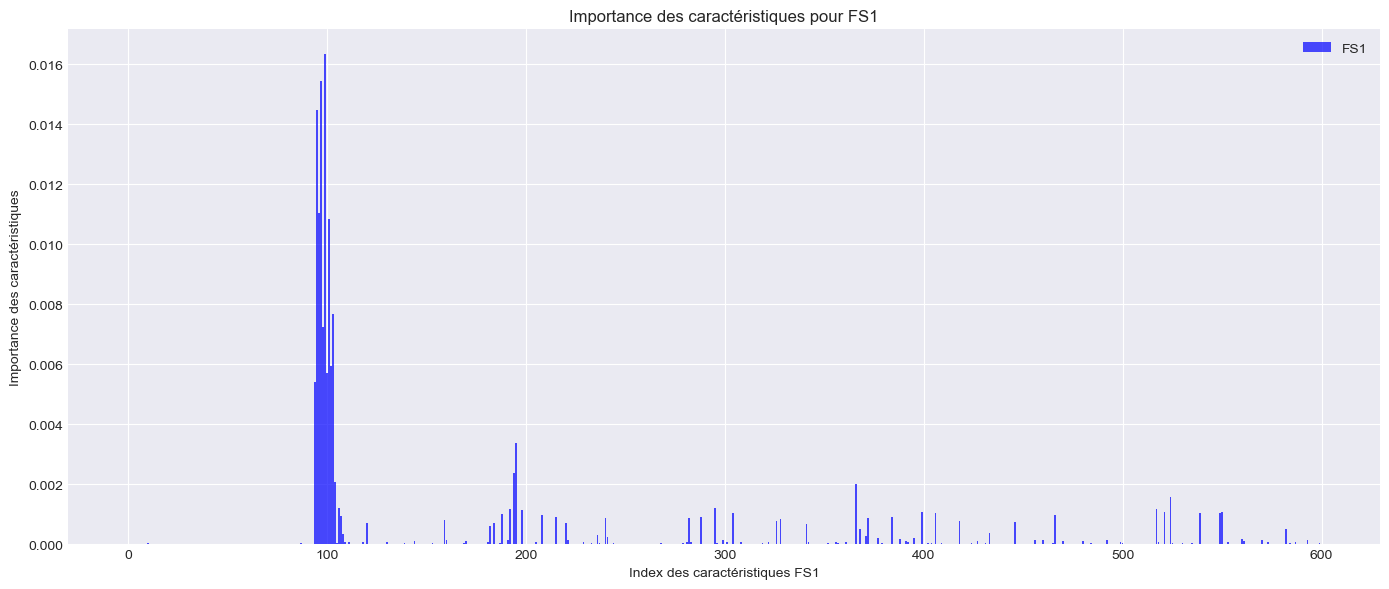

In [13]:
plot_sensor_importances(X, rf.feature_importances_, sensor_name="FS1")

# Conclusion

- Pour terminer, on peut s'amuser à rechercher la variable qui utilisée seule permet d'aboutir à la meilleure fiabilité de prévision.
- On introduit pour chaque capteur et chaque cycle les paramètres basés sur les moments d'ordre 1 à 4 (moyenne, variance, skewness et kurtosis).
- On remarque enfin que skewness et kurtosis du capteur PS2 permettent de prédire l'état de la valve avec une excellente fiabilité (voir dernière cellule de code ci-dessous).

In [15]:
unique_features = {
    'fs1_99': X['fs1'].iloc[:, 99],
    'fs1_100': X['fs1'].iloc[:, 100],
    'fs1_101': X['fs1'].iloc[:, 101],
    'ps2_950': X['ps2'].iloc[:, 950],
    'ps2_951': X['ps2'].iloc[:, 951],
    'ps2_952': X['ps2'].iloc[:, 952],
    'ps2_953': X['ps2'].iloc[:, 953],
    'fs1_mean': X['fs1'].mean(axis=1),
    'fs1_var': X['fs1'].var(axis=1),
    'fs1_skewness': X['fs1'].skew(axis=1),
    'fs1_kurtosis': X['fs1'].kurtosis(axis=1),
    'ps2_mean': X['ps2'].mean(axis=1),
    'ps2_var': X['ps2'].var(axis=1),
    'ps2_skewness': X['ps2'].skew(axis=1),
    'ps2_kurtosis': X['ps2'].kurtosis(axis=1)
}

for k, v in unique_features.items():
    rf, accuracy = train_model(v.values.reshape(-1, 1), y, training_samples=2000, plot_cm=False)
    print(f"Fiabilité sur l'ensemble de test avec {k} : {accuracy}")

Fiabilité sur l'ensemble de test avec fs1_99 : 0.8
Fiabilité sur l'ensemble de test avec fs1_100 : 0.7170731707317073
Fiabilité sur l'ensemble de test avec fs1_101 : 0.6390243902439025
Fiabilité sur l'ensemble de test avec ps2_950 : 0.824390243902439
Fiabilité sur l'ensemble de test avec ps2_951 : 0.7853658536585366
Fiabilité sur l'ensemble de test avec ps2_952 : 0.8195121951219512
Fiabilité sur l'ensemble de test avec ps2_953 : 0.8146341463414634
Fiabilité sur l'ensemble de test avec fs1_mean : 0.22439024390243903
Fiabilité sur l'ensemble de test avec fs1_var : 0.32682926829268294
Fiabilité sur l'ensemble de test avec fs1_skewness : 0.37073170731707317
Fiabilité sur l'ensemble de test avec fs1_kurtosis : 0.35121951219512193
Fiabilité sur l'ensemble de test avec ps2_mean : 0.5024390243902439
Fiabilité sur l'ensemble de test avec ps2_var : 0.6097560975609756
Fiabilité sur l'ensemble de test avec ps2_skewness : 1.0
Fiabilité sur l'ensemble de test avec ps2_kurtosis : 0.9951219512195122
